<a href="https://colab.research.google.com/github/hyulianton/jejaringsosial/blob/master/js_%F0%9F%90%8D_Implementasi_Komparatif_Deteksi_Komunitas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🐍 Implementasi Komparatif Deteksi Komunitas (Community Detection)

*Notebook* ini mengimplementasikan tiga metode deteksi komunitas utama: Louvain, Girvan-Newman, dan Label Propagation Algorithm (LPA).

### Cell 1: Persiapan Lingkungan dan Instalasi Library

Kita perlu menginstal *library* eksternal untuk Algoritma Louvain.

In [1]:
# ==========================================================
# CELL 1: INSTALASI DAN IMPORT LIBRARY
# ==========================================================

# Instalasi library python-louvain (sering disebut community)
# Library ini sangat efisien untuk menghitung dan mengoptimalkan Modularitas (Q)
!pip install python-louvain networkx matplotlib -q

import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools # Untuk Algoritma Girvan-Newman

### Cell 2: Memuat Dataset dan Visualisasi Jaringan Awal

Kita akan menggunakan **Jaringan Klub Karate Zachary** yang sudah tersedia di NetworkX.

Jaringan dimuat: Zachary's Karate Club
Jumlah Simpul (Nodes): 34
Jumlah Ikatan (Edges): 78


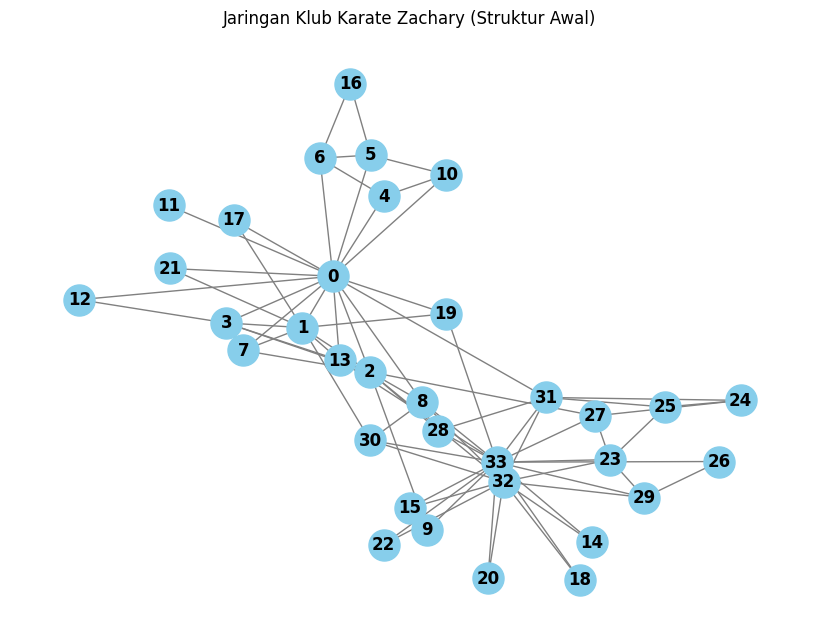

In [2]:
# ==========================================================
# CELL 2: MUAT DATASET DAN VISUALISASI JARINGAN AWAL
# ==========================================================

# Muat Jaringan Klub Karate Zachary
G = nx.karate_club_graph()

print(f"Jaringan dimuat: {G.name}")
print(f"Jumlah Simpul (Nodes): {G.number_of_nodes()}")
print(f"Jumlah Ikatan (Edges): {G.number_of_edges()}")

# Visualisasi Jaringan Awal
pos = nx.spring_layout(G, seed=42) # Layout agar node tidak tumpang tindih

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray', font_weight='bold')
plt.title("Jaringan Klub Karate Zachary (Struktur Awal)")
plt.show()

### Cell 3: Fungsi Pembantu untuk Evaluasi dan Visualisasi

Kita definisikan fungsi untuk menghitung Modularitas dan memplot hasil partisi secara konsisten.

In [3]:
# ==========================================================
# CELL 3: FUNGSI PEMBANTU (EVALUASI & VISUALISASI)
# ==========================================================

def plot_communities(G, partition, title):
    """Memvisualisasikan jaringan dengan simpul diwarnai berdasarkan komunitas."""

    # Hitung Nilai Modularitas (Q)
    Q = community_louvain.modularity(partition, G)

    # Tentukan jumlah komunitas dan skema warna
    community_ids = list(partition.values())
    num_communities = max(community_ids) + 1

    # Gunakan skema warna 'Set1' (terbaik untuk < 9 komunitas)
    cmap = plt.cm.get_cmap('Set1', num_communities)

    plt.figure(figsize=(8, 6))

    # Gambar simpul dengan warna komunitas
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=500,
                           cmap=cmap, node_color=community_ids, label=True)

    # Gambar ikatan dan label
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    plt.title(f"{title}\nModularitas (Q) = {Q:.4f}")
    plt.axis('off')
    plt.show()
    return Q, num_communities


def to_partition_dict(communities):
    """Mengubah format set of frozenset (output NetworkX) menjadi dictionary (input modularity)"""
    partition_dict = {}
    for i, community_set in enumerate(communities):
        for node in community_set:
            partition_dict[node] = i
    return partition_dict

### Cell 4: Implementasi Algoritma 1: Louvain (Optimasi Modularitas)

Algoritma Louvain adalah metode yang cepat dan efisien. Ia berupaya memaksimalkan nilai Modularitas ($Q$) secara iteratif.

⏳ Menjalankan Algoritma Louvain...


/tmp/ipython-input-1167492260.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', num_communities)


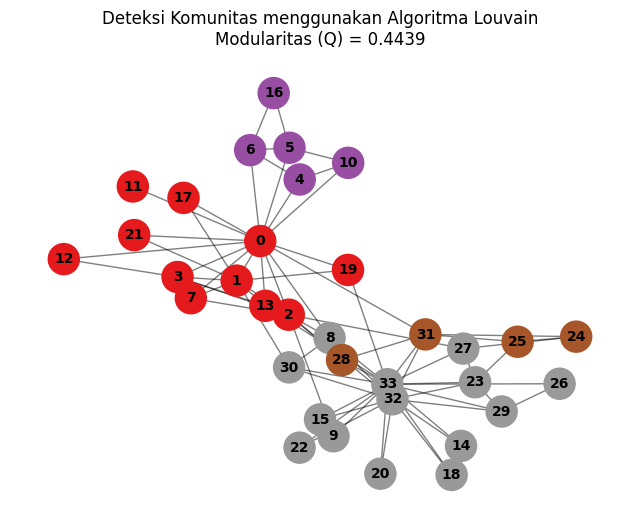

In [4]:
# ==========================================================
# CELL 4: ALGORITMA 1: LOUVAIN (THE EFFICIENT OPTIMIZER)
# ==========================================================

print("⏳ Menjalankan Algoritma Louvain...")

# Algoritma Louvain otomatis mencari partisi yang memberikan Q maksimum
partition_louvain = community_louvain.best_partition(G)

Q_louvain, comm_louvain = plot_communities(
    G,
    partition_louvain,
    "Deteksi Komunitas menggunakan Algoritma Louvain"
)

### Cell 5: Implementasi Algoritma 2: Girvan-Newman (Divisive Clustering)

Algoritma Girvan-Newman adalah metode *divisive* (pemisahan) yang bekerja dengan menghapus ikatan dengan *Edge Betweenness Centrality* tertinggi secara berulang. Kita akan mencari partisi optimal dengan $Q$ maksimum.

⏳ Menjalankan Algoritma Girvan-Newman...


/tmp/ipython-input-1167492260.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', num_communities)


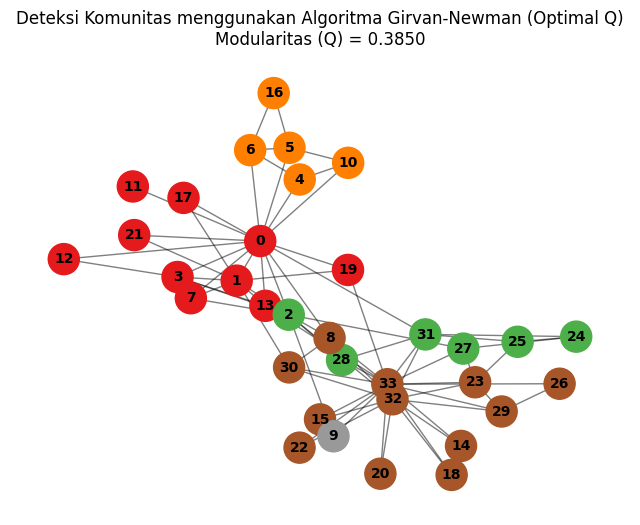

In [5]:
# ==========================================================
# CELL 5: ALGORITMA 2: GIRVAN-NEWMAN (THE ELEGANT DIVIDER)
# ==========================================================

print("⏳ Menjalankan Algoritma Girvan-Newman...")

# Girvan-Newman mengembalikan generator dari partisi (berbagai level)
comp = nx.community.girvan_newman(G)

best_partition_gn = None
max_q_gn = -1.0
comm_gn = 0

# Iterasi melalui setiap partisi (setelah setiap penghapusan edge)
for communities in comp:
    # Ubah format ke dictionary untuk perhitungan Modularitas
    current_partition = to_partition_dict(communities)
    current_q = community_louvain.modularity(current_partition, G)

    if current_q > max_q_gn:
        max_q_gn = current_q
        best_partition_gn = current_partition
        comm_gn = len(communities)

    # Hentikan iterasi setelah mencapai terlalu banyak komunitas (misal, > 5)
    if len(communities) >= 5:
        break

# Visualisasi partisi Girvan-Newman dengan Q tertinggi
Q_gn, comm_gn = plot_communities(
    G,
    best_partition_gn,
    "Deteksi Komunitas menggunakan Algoritma Girvan-Newman (Optimal Q)"
)

### Cell 6: Implementasi Algoritma 3: Label Propagation Algorithm (LPA)

LPA adalah algoritma berbasis *propagasi label* (aturan mayoritas tetangga) yang dikenal sangat cepat, meskipun non-deterministik.

⏳ Menjalankan Algoritma Label Propagation...


/tmp/ipython-input-1167492260.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', num_communities)


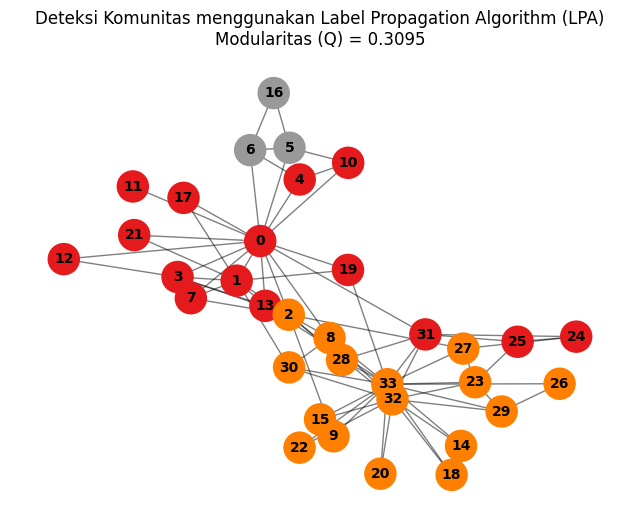

In [8]:
# ==========================================================
# CELL 6: ALGORITMA 3: LABEL PROPAGATION (THE RAPID GOSSIPER)
# ==========================================================

print("⏳ Menjalankan Algoritma Label Propagation...")

# LPA dari NetworkX
# Karena non-deterministik, hasil mungkin bervariasi pada setiap running
communities_lpa = nx.community.label_propagation_communities(G)

# Ubah format (set of frozenset) ke dictionary (untuk visualisasi dan Q).
# Kita pastikan fungsi to_partition_dict() dari Cell 3 sudah dieksekusi.
partition_lpa = to_partition_dict(communities_lpa)

# Visualisasi partisi LPA
Q_lpa, comm_lpa = plot_communities(
    G,
    partition_lpa,
    "Deteksi Komunitas menggunakan Label Propagation Algorithm (LPA)"
)

### Cell 7: Komparasi Hasil

Kita bandingkan kualitas (Modularitas) dan jumlah komunitas yang ditemukan oleh ketiga algoritma.

HASIL KOMPARASI METODE DETEKSI KOMUNITAS:
          Metode  Modularitas (Q)  Jumlah Komunitas
0        Louvain           0.4439                 4
1  Girvan-Newman           0.3850                 5
2            LPA           0.3095                 3


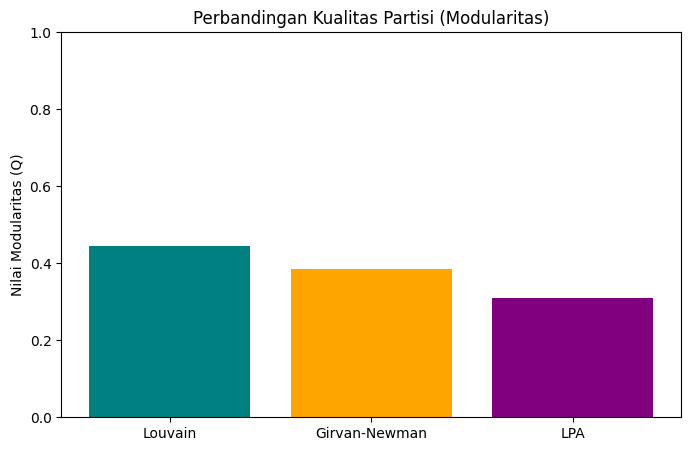

In [9]:
# ==========================================================
# CELL 7: KOMPARASI HASIL
# ==========================================================

# Data hasil komparasi
results = pd.DataFrame({
    'Metode': ['Louvain', 'Girvan-Newman', 'LPA'],
    'Modularitas (Q)': [Q_louvain, Q_gn, Q_lpa],
    'Jumlah Komunitas': [comm_louvain, comm_gn, comm_lpa]
})

print("=" * 50)
print("HASIL KOMPARASI METODE DETEKSI KOMUNITAS:")
print("=" * 50)
print(results.round(4))

# Visualisasi komparasi Modularitas
plt.figure(figsize=(8, 5))
plt.bar(results['Metode'], results['Modularitas (Q)'], color=['teal', 'orange', 'purple'])
plt.ylabel("Nilai Modularitas (Q)")
plt.title("Perbandingan Kualitas Partisi (Modularitas)")
plt.ylim(0.0, 1.0)
plt.show()

# Kesimpulan:
# - Algoritma Louvain dan Girvan-Newman cenderung menghasilkan nilai Q yang lebih tinggi karena
#   mereka didesain untuk mengoptimalkan Modularitas.
# - LPA sangat cepat tetapi hasilnya seringkali suboptimal atau bervariasi (non-deterministik).